Kernels and Pseudo-Linear Models
============================

In this Jupyter Notebook...

* Use SVM to define the decision boundary between to linearly separable clusters within a data set

* Demonstrate how $\lambda$ affects the determination of the boundary and the margin

* Apply a polynomial kernel within the SVM to model nonlinear classification

Import the necessary modules

In [1]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import random
from scipy.spatial import Voronoi, voronoi_plot_2d

from sklearn import svm

from pathlib import Path

output_folder = Path('figures/')

Define functions for the SVM optimization

In [2]:
def xi_calc(x, t, w):
    r"""
    Calculate Xi as the summand of the hinge cost within the SVM cost function

    Parameters
    ----------
    x : int array
        Vector of the discrete dependent variable (negative ones and ones)
    t : float array
        Covariate vector
    w : float array
        Weight vector

    Returns
    -------
    xi : float array
        Evaluated $\xi$ function for the hinge cost

    """

    tw_dot = np.dot(t, w[1:]) + w[0]
    xi = np.maximum(np.zeros(len(x)), 1 - x * tw_dot)

    return xi


def jsvm_calc(x, t, w, lam):
    r"""
    Calculate the SVM cost function

    Parameters
    ----------
    x : int array
        Vector of the discrete dependent variable (negative ones and ones)
    t : float array
        Covariate vector
    w : float array
        Weight vector

    Returns
    -------
    jsmv : float array
        SVM cost function

    """

    n_e = len(x)
    xi = xi_calc(x, t, w)

    jsvm = np.sum(xi) + lam * n_e * np.sum(w[1:] ** 2)

    return jsvm


def jsvm_gradient_calc(x, t, w, lam):
    r"""
    Calculate the gradient of the SVM cost function with respect to the weight vector

    Parameters
    ----------
    x : int array
        Vector of the discrete dependent variable (negative ones and ones)
    t : float array
        Covariate vector
    w : float array
        Weight vector

    Returns
    -------
    jsmv_gradient : float array
        Gradient of JSVM

    """

    n_e = len(x)
    n_t = len(w) - 1
    tw_dot = np.dot(t, w[1:]) + w[0]
    h_xi = np.heaviside(1 - x * tw_dot, 1)

    jsvm_grad = np.zeros(n_t + 1)
    jsvm_grad[0] = - np.mean(h_xi * x)
    jsvm_grad[1:] = - np.mean(np.transpose(np.transpose(t) * (h_xi * x)), axis=0) + 2 * lam * w[1:]
    jsvm_grad *= n_e

    return jsvm_grad

Generate the random variables

In [3]:
k_actual = 2
x0 = np.random.uniform(-10,10,(k_actual, 2))
ind_sort = np.argsort(x0[:, 0])
x0 = x0[ind_sort, :]
alpha = np.random.uniform(0,2 * np.pi, k_actual)
st_dev = np.random.uniform(2,3.5,(k_actual,2))

u0 = np.transpose(np.array([np.cos(alpha), np.sin(alpha)]))

In [4]:
num_tot = 100

x_data = np.zeros((num_tot, 2))
ind_data = np.zeros(num_tot, dtype = 'int')

for i in range(num_tot):
    ind_i = np.random.randint(0, k_actual)
    ind_data[i] = 2 * ind_i - 1
    x0_i = x0[ind_i, :]
    delx_0 = st_dev[ind_i, 0] * np.random.randn()
    delx_1 = st_dev[ind_i, 1] * np.random.randn()

    x_data[i, :] = x0_i + delx_0 * u0[0,:] + delx_1 * u0[1,:]

Plot the raw data

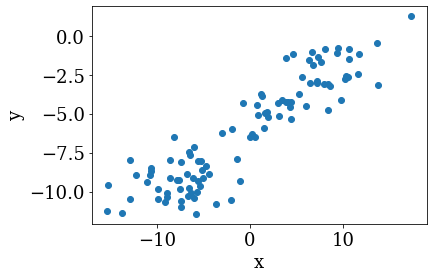

In [5]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(x_data[:, 0], x_data[:, 1])

plt.xlabel('x')
plt.ylabel('y')    
    
#plt.xlim([-15, 0])
#plt.ylim([-6, 15])

#plt.savefig('figures/unsupervised_learning/k_mean_data' + '.pdf', bbox_inches='tight')
plt.show()

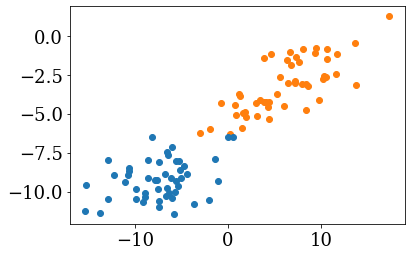

In [6]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

for i in range(num_tot):
    col_val = 'C' + str(int((ind_data[i]+1)/2))
    plt.scatter(x_data[i, 0], x_data[i, 1], color = col_val)

    
#plt.xlim([-15, 0])
#plt.ylim([-6, 15])

plt.savefig('figures/boundary.pdf', bbox_inches='tight')    
plt.show()

Assume the data is linearly separable, and train the data on a SVM with a linear kernel

In [7]:
t = x_data
x = ind_data

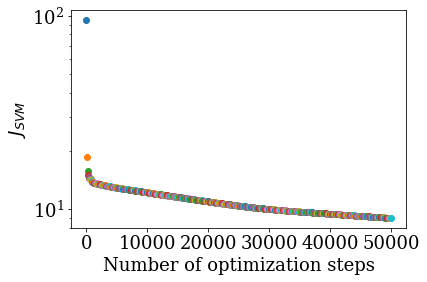

In [8]:
w=np.array([0,0,0])
lam=0.1

del_plot = 100

plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

dt_opt=0.00001
num_opt=50000
for i in range(num_opt):
    dj_dw = jsvm_gradient_calc(x, t, w, lam)
    w = w - dj_dw * dt_opt

    if i % del_plot == 0:
        jsmv = jsvm_calc(x, t, w, lam)
        plt.scatter(i, jsmv)
        
w_grad_opt = w

plt.xlabel('Number of optimization steps')    
plt.ylabel('$J_{SVM}$')

    
plt.yscale('log')

#plt.xlim([-15, 0])
#plt.ylim([-6, 15])

plt.savefig('figures/unsupervised_learning/k_mean_data' + '.pdf', bbox_inches='tight')
plt.show()

Perform optimization of $w$ using the svm module within sklearn 

In [9]:
lam = 0.1
svm_train = svm.SVC(kernel='linear', C = 1 / (2 * num_tot * lam)) # Linear Kernel
svm_train.fit(t, x)
w = np.array([svm_train.intercept_[0], svm_train.coef_[0][0], svm_train.coef_[0][1]])
x_pred = svm_train.predict(t)
margin = 1 / np.sqrt(np.sum(w[1:] ** 2))
accuracy = np.sum(x * x_pred + 1) / 2 / num_tot

Plot the decision boundary and the label boundaries

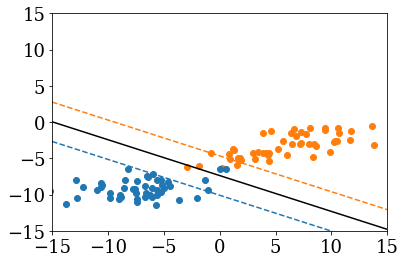

In [10]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

for i in range(num_tot):
    col_val = 'C' + str(int((ind_data[i]+1)/2))
    plt.scatter(x_data[i, 0], x_data[i, 1], color = col_val)

    
t1 = np.linspace(-20, 20, 100)
t2 = -w[1] / w[2] * t1 - w[0] / w[2]
plt.plot(t1, t2, 'k-')
plt.plot(t1, t2 + 1 / w[2], '--', color = 'C1')
plt.plot(t1, t2 - 1 / w[2], '--', color = 'C0')

t2 = -w_grad_opt[1] / w_grad_opt[2] * t1 - w_grad_opt[0] / w_grad_opt[2]
#plt.plot(t1, t2, 'k-')
#plt.plot(t1, t2 + 1 / w_grad_opt[2], '--', color = 'C1')
#plt.plot(t1, t2 - 1 / w_grad_opt[2], '--', color = 'C0')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

#plt.savefig('figures/boundary.pdf', bbox_inches='tight')    
plt.show()

In [11]:
w

array([2.71581174, 0.18182023, 0.36799652])

In [12]:
w_grad_opt

array([1.50319   , 0.22403252, 0.17548991])

Generate a data set with a nonlinear decision boundary

In [13]:
num_tot = 100

x0 = np.array([0.5, 1])
del_cutoff = 0.45
del_bound = 0.01

x_data = np.zeros((num_tot, 2))
ind_data = np.zeros(num_tot, dtype = 'int')

for i in range(num_tot):    
    x_i = np.random.uniform(0, 1, (2))
    del_x = np.sqrt(np.sum((x_i - x0) ** 2))
    prob = 0.5 * (1 + np.tanh(- (del_x - del_cutoff) / del_bound))
    x_data[i, :] = x_i
    if np.random.uniform(0, 1) < prob:
        ind_data[i] = 1
    else:
        ind_data[i] = -1

In [14]:
x_i

array([0.68560711, 0.45441363])

Plot the raw data

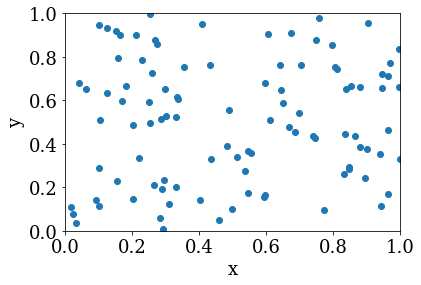

In [15]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(x_data[:, 0], x_data[:, 1])

plt.xlabel('x')
plt.ylabel('y')    
    
plt.xlim([0, 1])
plt.ylim([0, 1])

#plt.savefig('figures/unsupervised_learning/k_mean_data' + '.pdf', bbox_inches='tight')
plt.show()

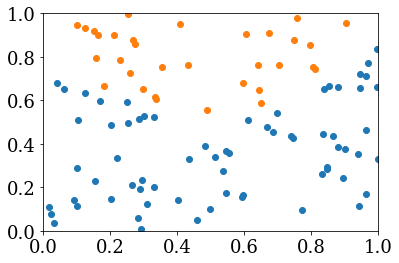

In [16]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

for i in range(num_tot):
    col_val = 'C' + str(int((ind_data[i]+1)/2))
    plt.scatter(x_data[i, 0], x_data[i, 1], color = col_val)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.savefig('figures/nonlinear.pdf', bbox_inches='tight')    
plt.show()

Perform SVM analysis with a quadratic kernel

In [17]:
t = x_data
x = ind_data

In [18]:
lam = 0.01
svm_train = svm.SVC(kernel='poly', C = 1 / (2 * num_tot * lam), degree = 3) # Polynomial Kernel
svm_train.fit(t, x)
#w = np.array([svm_train.intercept_[0], svm_train.coef_[0][0], svm_train.coef_[0][1]])
x_pred = svm_train.predict(t)
margin = 1 / np.sqrt(np.sum(w[1:] ** 2))
accuracy = np.sum(x * x_pred + 1) / 2 / num_tot

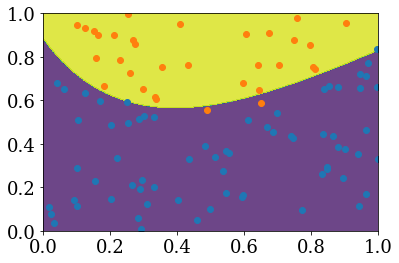

In [19]:
plt.figure()
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

num_pt = 500
t1 = np.linspace(0,1,num_pt)
t2 = np.linspace(0,1,num_pt)
predict = np.zeros((num_pt,num_pt))

for i1 in range(num_pt):
    for i2 in range(len(t2)):
        predict[i2, i1] = svm_train.predict([[t1[i1],t2[i2]]])

plt.contourf(t1, t2, predict, alpha=.8)

for i in range(num_tot):
    col_val = 'C' + str(int((ind_data[i]+1)/2))
    plt.scatter(x_data[i, 0], x_data[i, 1], color = col_val)

plt.xlim([0, 1])
plt.ylim([0, 1])

#plt.savefig('figures/nonlinear_boundary.pdf', bbox_inches='tight')    
plt.show()